In [1]:
import torch as t
from transformers import GPT2LMHeadModel, GPT2Tokenizer  # pip install transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt 
import time
import numpy as np
import sklearn
import pickle
import re  # regular expressions, useful for decoding the output 

2023-04-26 12:12:37.953037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_LLM(default="EleutherAI/gpt-neo-2.7B", device='cpu'):
    """(1 pt) Load a pretrained LLM and put on device. Default choice is a large-ish GPT-neo-2.7B model on Huggingface.
    Could also consider the "open GPT" from facebook: "facebook/opt-2.7b", or others
    here: https://huggingface.co/models?pipeline_tag=text-generation
    Explicitly load model and tokenizer, don't use the huggingface "pipeline" which hides details of the model
    (and it also has no batch processing, which we need here)
    """
    # TODO
    tokenizer = AutoTokenizer.from_pretrained(default)
    model = AutoModelForCausalLM.from_pretrained(default).to(device)
    return model, tokenizer

In [3]:
model, tokenizer = load_LLM()

In [4]:
def create_dataset(i_start=0, i_end=50, operation=t.add):
    """(1 pt) Create a dataset of pairs of numbers to calculate an operation on.
    DO NOT USE A FOR LOOP. Use pytorch functions, possibilities include meshgrid, stack, reshape, repeat, tile.
    (Note you'll have to use for loops on string stuff in other functions)

    The dataset should be a tuple of two tensors, X and y, where X is a Nx2 tensor of numbers to add,
    and y is a N tensor of the correct answers.
    E.g., if i_start=0, i_end=2, then X should be tensor([[0,0,1,1],[0,1,0,1]]).T and y should be tensor([0,1,1,2]).
    I recommend doing all pairs of sums involving 0-49, but you may modify this.
    """
    # TODO 
    a = t.arange(i_start, i_end)
    b = t.arange(i_start, i_end)
    a, b = t.meshgrid(a, b) 
    a = a.reshape(-1)
    b = b.reshape(-1) 
    X = t.stack((a, b), dim=1) 
    y = operation(X[:, 0], X[:, 1])
    return X, y

In [5]:
X, y = create_dataset()

/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
X, y

(tensor([[ 0,  0],
         [ 0,  1],
         [ 0,  2],
         ...,
         [49, 47],
         [49, 48],
         [49, 49]]),
 tensor([ 0,  1,  2,  ..., 96, 97, 98]))

In [7]:
def encode_problems(X, strategy='baseline'):
    output_strings = []
    for xi in X:
        if strategy == 'baseline':
            encode_string = str(xi[0].item())+"+"+str(xi[1].item())+"="
        elif strategy == 'new':
            encode_string = f"if x={xi[0].item()} and y={xi[1].item()} then z=x+y is the summation of variable x and y. In this case, z=" 
            
        output_strings.append(encode_string)
    return output_strings 

In [8]:
def generate_text(model, tokenizer, prompts, verbose=True, device='cpu'):
    # TODO: tokenize 
    # TODO: generate text, turn off gradient tracking  
    # TODO: decode output, output_strings = ... 
    
    t0 = time.time()
    inputs = tokenizer(prompts, return_tensors='pt').to(device) 
    output_strings = []
    batch_size = 32

    with t.no_grad():
        for i in range(0, len(inputs['input_ids']), batch_size):
            print(f"batch {int(i/batch_size)} ...", end=" ")
            batch_inputs = {k: v[i:i+batch_size] for k, v in inputs.items()}
            output = model.generate(**batch_inputs, max_length=len(inputs['input_ids'][0])+1, pad_token_id=50256, do_sample=False, temperature=0.001)
            batch_outputs = [tokenizer.decode(o) for o in output]  
            output_strings += batch_outputs

    if verbose:
        # TODO: print example tokenization for write-up
        for prompt, output_string in zip(prompts[-10:], output_strings[-10:]):
            input_tokens = tokenizer.tokenize(prompt)
            output_tokens = tokenizer.tokenize(output_string)
            print(f"Input: {input_tokens}")
            print(f"Output: {output_tokens}")
    
    print("Time to generate text: ", time.time() - t0)  # It took 4 minutes to do 25000 prompts on an NVIDIA 1080Ti.
    return output_strings

In [9]:
def decode_output(output_strings, strategy='baseline', verbose=True):
    y_hat = []
    for s in output_strings:
        # TODO: 
        tmp = tokenizer.tokenize(s)[-1]
        #print(tmp)
        if not tmp[0].isdigit():
            y_hat.append(t.nan) 
        else:
            y_hat.append(int(tmp))
    return y_hat 

In [10]:
def compare_and_plot(a, b, scatter_title="Scatter Plot"): 
    not_nan = (~t.isnan(a)) & (~t.isnan(b))
    matches = not_nan & (a.eq(b))
    binary = t.zeros_like(a, dtype=t.int)
    binary[matches] = 1
    zeros = X[binary == 0]
    ones = X[binary == 1] 
    acc = sum(binary)/len(binary) 
    print(f"Accuracy : {acc}")
    # plot the data
    plt.figure(figsize=(10,10))
    plt.scatter(zeros[:, 0], zeros[:, 1], marker='s', label='Incorrect')
    plt.scatter(ones[:, 0], ones[:, 1], marker='o', label='Correct') 
    plt.title(scatter_title)
    plt.legend()
    plt.show()
    return binary

## Baseline Encoding

In [155]:
inputs = encode_problems(X) 
print("Encoding done! \nGenerating texts ... ")
outputs = generate_text(model, tokenizer, inputs) 
print('Text genration done! ')
pred_sums = decode_output(outputs)
y_hat = t.tensor(pred_sums)

Encoding done! 
Generating texts ... 
batch 0 ... batch 1 ... batch 2 ... batch 3 ... batch 4 ... batch 5 ... batch 6 ... batch 7 ... batch 8 ... batch 9 ... batch 10 ... batch 11 ... batch 12 ... batch 13 ... batch 14 ... batch 15 ... batch 16 ... batch 17 ... batch 18 ... batch 19 ... batch 20 ... batch 21 ... batch 22 ... batch 23 ... batch 24 ... batch 25 ... batch 26 ... batch 27 ... batch 28 ... batch 29 ... batch 30 ... batch 31 ... batch 32 ... batch 33 ... batch 34 ... batch 35 ... batch 36 ... batch 37 ... batch 38 ... batch 39 ... batch 40 ... batch 41 ... batch 42 ... batch 43 ... batch 44 ... batch 45 ... batch 46 ... batch 47 ... batch 48 ... batch 49 ... batch 50 ... batch 51 ... batch 52 ... batch 53 ... batch 54 ... batch 55 ... batch 56 ... batch 57 ... batch 58 ... batch 59 ... batch 60 ... batch 61 ... batch 62 ... batch 63 ... batch 64 ... batch 65 ... batch 66 ... batch 67 ... batch 68 ... batch 69 ... batch 70 ... batch 71 ... batch 72 ... batch 73 ... batch 74 .

In [156]:
y_hat, y 

(tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([ 0,  1,  2,  ..., 96, 97, 98]))

Accuracy : 0.014800000004470348


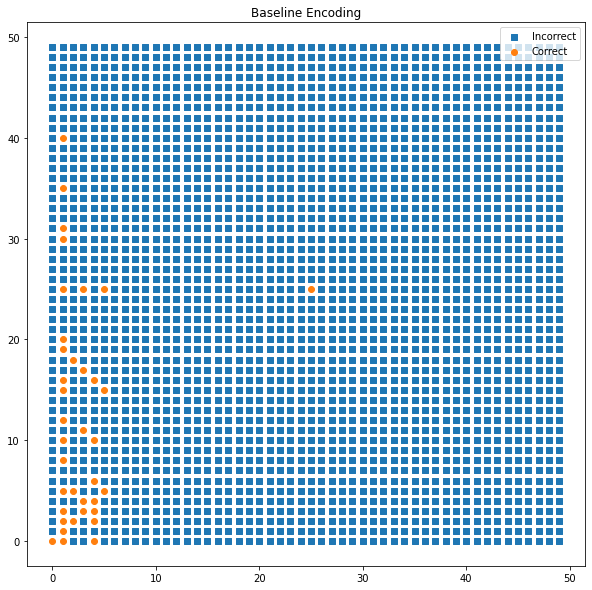

In [157]:
base_correctness = compare_and_plot(y_hat, y, scatter_title="Baseline Encoding")

## New Encoding

In [13]:
inputs2 = encode_problems(X, strategy='new') 
print(inputs2[0])

if x=0 and y=0 then z=x+y is the summation of variable x and y. In this case, z=


In [171]:
outputs2 = generate_text(model, tokenizer, inputs2)

if x=0 and y=0 then z=x+y is the summation of variable x and y. In this case, z=
batch 0 ... batch 1 ... batch 2 ... batch 3 ... batch 4 ... batch 5 ... batch 6 ... batch 7 ... batch 8 ... batch 9 ... batch 10 ... batch 11 ... batch 12 ... batch 13 ... batch 14 ... batch 15 ... batch 16 ... batch 17 ... batch 18 ... batch 19 ... batch 20 ... batch 21 ... batch 22 ... batch 23 ... batch 24 ... batch 25 ... batch 26 ... batch 27 ... batch 28 ... batch 29 ... batch 30 ... batch 31 ... batch 32 ... batch 33 ... batch 34 ... batch 35 ... batch 36 ... batch 37 ... batch 38 ... batch 39 ... batch 40 ... batch 41 ... batch 42 ... batch 43 ... batch 44 ... batch 45 ... batch 46 ... batch 47 ... batch 48 ... batch 49 ... batch 50 ... batch 51 ... batch 52 ... batch 53 ... batch 54 ... batch 55 ... batch 56 ... batch 57 ... batch 58 ... batch 59 ... batch 60 ... batch 61 ... batch 62 ... batch 63 ... batch 64 ... batch 65 ... batch 66 ... batch 67 ... batch 68 ... batch 69 ... batch 70 ... batch 

In [172]:
y_hat2 = t.tensor(decode_output(outputs2, strategy='new')) 

In [173]:
y_hat2, y

(tensor([nan,  1.,  2.,  ..., 49., 49., 49.]),
 tensor([ 0,  1,  2,  ..., 96, 97, 98]))

Accuracy : 0.03759999945759773


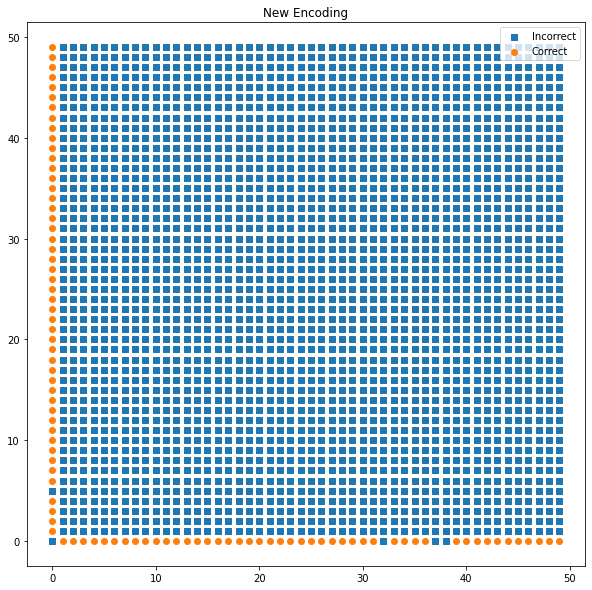

In [174]:
new_correctness = compare_and_plot(y_hat2, y, scatter_title="New Encoding") 

## Train a classifier

In [151]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 

Accuracy: 0.9826666666666667


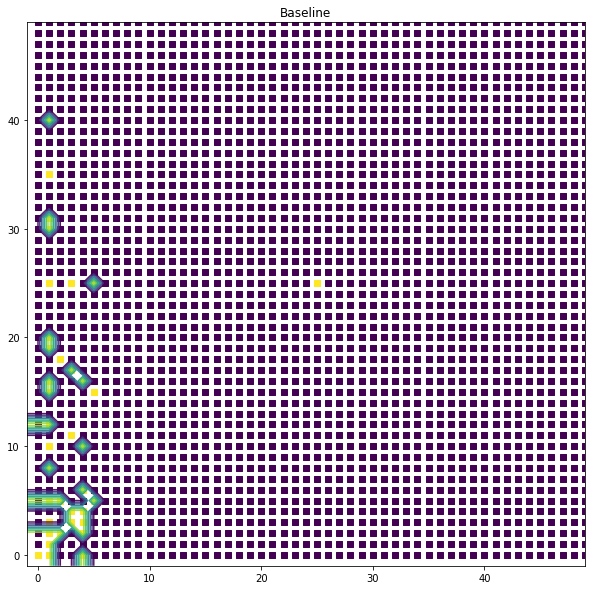

In [166]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, base_correctness, test_size=0.3, random_state=42, stratify=base_correctness) 
dtc1 = DecisionTreeClassifier()
dtc1.fit(X_train1, y_train1)
y_pred = dtc1.predict(X_test1)

print(f"Accuracy: {dtc1.score(X_test1, y_test1)}") 

# Create a meshgrid of points
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# Use the classifier to predict the class labels for each point in the meshgrid
Z = dtc1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the scatter plot and decision boundary
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], marker='s', c=base_correctness)
plt.contour(xx, yy, Z, alpha=0.9) 
plt.title("Baseline")
plt.show() 

Accuracy: 0.9986666666666667


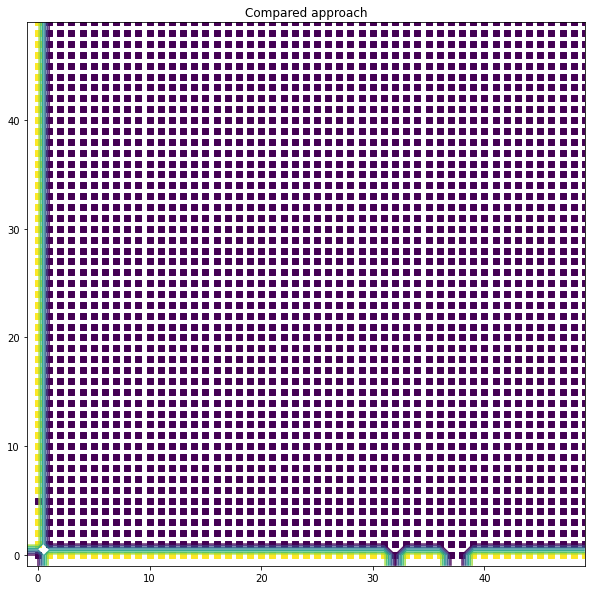

In [175]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, new_correctness, test_size=0.3, random_state=42, stratify=new_correctness) 
dtc2 = DecisionTreeClassifier()
dtc2.fit(X_train2, y_train2)
y_pred = dtc2.predict(X_test2)

print(f"Accuracy: {dtc2.score(X_test2, y_test2)}") 

# Create a meshgrid of points
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# Use the classifier to predict the class labels for each point in the meshgrid
Z = dtc2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the scatter plot and decision boundary
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1],marker='s', c=new_correctness) 
plt.contour(xx, yy, Z, alpha=0.9) 
plt.title("Compared approach")
plt.show() 



## Multiple Response

In [11]:
def generate_text_from_multiple(model, tokenizer, prompts, verbose=True, device='cpu'):
    # TODO: tokenize 
    # TODO: generate text, turn off gradient tracking  
    # TODO: decode output, output_strings = ... 
    
    t0 = time.time()
    output_strings = []

    with t.no_grad():
        for prompt in prompts:
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cpu') 
            nxt_toks = []
            # Generate multiple next tokens
            for i in range(10):
                output_ids = model.generate(
                    input_ids,
                    max_length=len(input_ids[0])+1,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=True,
                    temperature=0.6,
                )
                # Decode the output
                output_text = tokenizer.decode(output_ids[0][-1], skip_special_tokens=True) 
                if output_text[0].isdigit():
                    nxt_toks.append(int(output_text))
            print(nxt_toks) 
            if len(nxt_toks)==0:
                s = t.nan
            else:
                s = np.bincount(nxt_toks).argmax() 
            outputs = ' '.join([tokenizer.decode(o) for o in input_ids[0]])+str(s) 
            print(outputs)
            output_strings.append(outputs)

    if verbose:
        # TODO: print example tokenization for write-up
        for prompt, output_string in zip(prompts[-10:], output_strings[-10:]):
            input_tokens = tokenizer.tokenize(prompt)
            output_tokens = tokenizer.tokenize(output_string)
            print(f"Input: {input_tokens}")
            print(f"Output: {output_tokens}")
    
    print("Time to generate text: ", time.time() - t0)  
    return output_strings

In [14]:
outputs3 = generate_text_from_multiple(model, tokenizer, inputs2)

[2, 3, 1, 0, 1, 0, 0, 1]
if  x = 0  and  y = 0  then  z = x + y  is  the  summ ation  of  variable  x  and  y .  In  this  case ,  z =0
[0, 2, 2, 1, 1, 1]
if  x = 0  and  y = 1  then  z = x + y  is  the  summ ation  of  variable  x  and  y .  In  this  case ,  z =1
[2, 6, 6, 5, 3, 3, 0]
if  x = 0  and  y = 2  then  z = x + y  is  the  summ ation  of  variable  x  and  y .  In  this  case ,  z =3
[5, 6, 5, 6, 5, 12, 3, 7, 2, 6]
if  x = 0  and  y = 3  then  z = x + y  is  the  summ ation  of  variable  x  and  y .  In  this  case ,  z =5
[6, 4, 9, 6, 4, 2, 5, 4, 10]
if  x = 0  and  y = 4  then  z = x + y  is  the  summ ation  of  variable  x  and  y .  In  this  case ,  z =4
[5, 5, 3, 15, 5, 10, 2, 4, 0, 10]
if  x = 0  and  y = 5  then  z = x + y  is  the  summ ation  of  variable  x  and  y .  In  this  case ,  z =5
[6, 0, 6, 14, 12, 6, 6, 6]
if  x = 0  and  y = 6  then  z = x + y  is  the  summ ation  of  variable  x  and  y .  In  this  case ,  z =6
[3, 13, 7, 7, 7, 10, 7, 0, 2, 2]
if

Accuracy : 0.03840000182390213


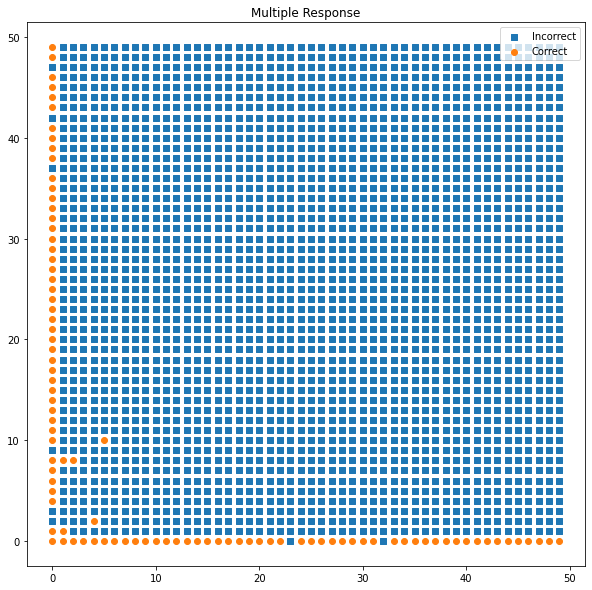

In [16]:
y_hat3 = t.tensor(decode_output(outputs3)) 
new_2 = compare_and_plot(y_hat3, y, scatter_title="Multiple Response")

## Distribution of next token probabilities

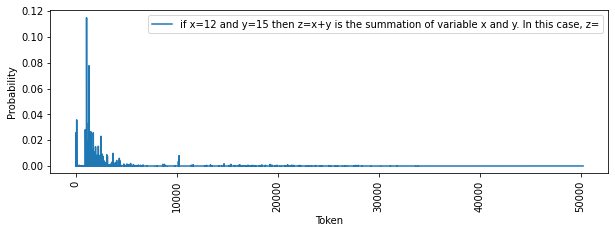

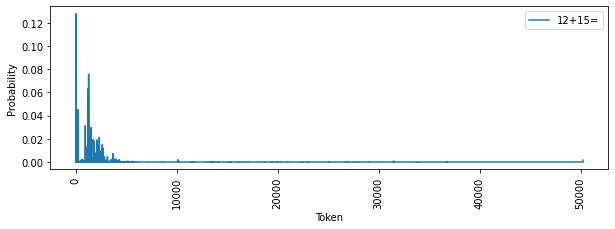

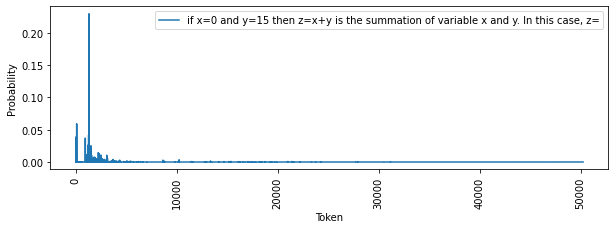

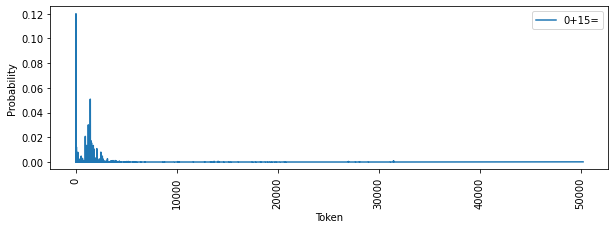

In [33]:
prompts = ["if x=12 and y=15 then z=x+y is the summation of variable x and y. In this case, z=", "12+15=",
           "if x=0 and y=15 then z=x+y is the summation of variable x and y. In this case, z=", "0+15=",]

# Loop over the prompts and generate sequences
for prompt in prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    with t.no_grad():
        outputs = model(input_ids)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_probs = t.softmax(next_token_logits, dim=-1)

    tokens = [tokenizer.decode([i]) for i in range(len(next_token_probs[0]))]
    probs = [prob.item() for prob in next_token_probs[0]]
    plt.figure(figsize=(10,3))
    plt.plot(probs, label=prompt)
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()